<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/InriaAerialImages/Inference_slidingwindowpatches256_wpad_overlap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up fastai in colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Copying the tar file to colab memory
!mkdir 'InriaPatches'
!cp 'drive/My Drive/256_tif_files/test.tar' 'InriaPatches/'

In [0]:
!tar -zxf InriaPatches/test.tar -C InriaPatches/

In [0]:
# Remove all the tar files
!rm -rf InriaPatches/*.tar

In [3]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import torch
import torchvision.transforms.functional as F
from tqdm import tqdm
print(fastai.__version__)

1.0.52


In [0]:
root_dir = Path('InriaPatches')
test_path = root_dir/'test'

In [0]:
test = get_image_files(test_path)

In [4]:
len(test)

72000

In [4]:
# Size of each image 
image = open_image(test[0])
img_size = np.array(image.shape[1:])
print(image.shape)

torch.Size([3, 256, 256])


5


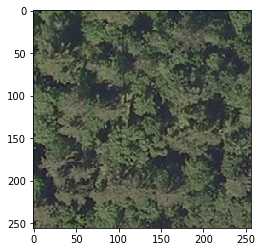

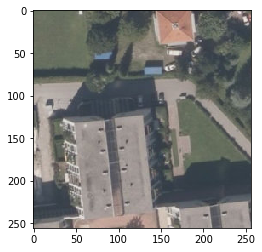

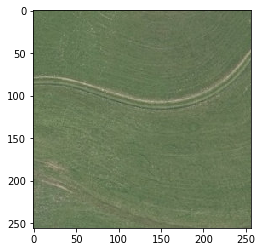

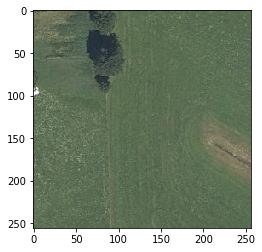

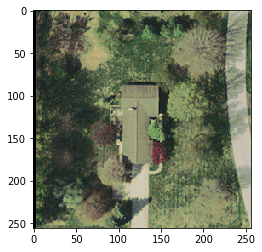

In [7]:
import matplotlib.pyplot as plt

'''Display a sample of random test images'''
def display_image_mask_grid(n):
  images_list = []
  for i in range(n):
    images_list.append(random.choice(os.listdir(test_path)))
  print(len(images_list))
  for idx, image in enumerate(images_list):  
    img = plt.imread(str(test_path/image))
    plt.imshow(img)
    plt.show()

display_image_mask_grid(5)

In [0]:
#Copying the saved model file from drive
!cp 'drive/My Drive/256_tif_files/bestIOU_5.pkl'  '/content/InriaPatches/'

In [0]:
def jaccard_loss(input, target):
  smooth = 1.
  input = input[:,1,None].sigmoid()
  iflat = input.contiguous().view(-1).float()
  tflat = target.view(-1).float()
  intersection = (iflat * tflat).sum()
  cardinality = (iflat + tflat).sum()
  union = cardinality - intersection
  return (1 - ((intersection + smooth) / (union + smooth)))

def combo_loss(pred, targ):
  bce_loss = CrossEntropyFlat(axis=1)
  return bce_loss(pred,targ) + jaccard_loss(pred,targ)

In [0]:
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False

In [9]:
bs=16
codes = np.array(['NotBuilding','Building'])
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder().label_from_func(get_mask_file, classes=codes).add_test_folder(test_folder='test')
data_test = (src.databunch(bs=bs).normalize(imagenet_stats))

### Instead of MaskSegmentationItemList can we use ImageImageList during inference phase??

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:442: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:445: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [0]:
learn = load_learner('/content/InriaPatches','bestIOU_5.pkl')

In [0]:
learn.data = data_test

In [15]:
learn.data

ImageDataBunch;

Train: LabelList (0 items)
x: MaskSegmentationItemList

y: MaskSegmentationLabelList

Path: InriaPatches;

Valid: LabelList (0 items)
x: MaskSegmentationItemList

y: MaskSegmentationLabelList

Path: InriaPatches;

Test: LabelList (72000 items)
x: MaskSegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: InriaPatches

In [0]:
preds = learn.pred_batch(ds_type=DatasetType.Test)

In [19]:
preds.shape

torch.Size([16, 2, 256, 256])

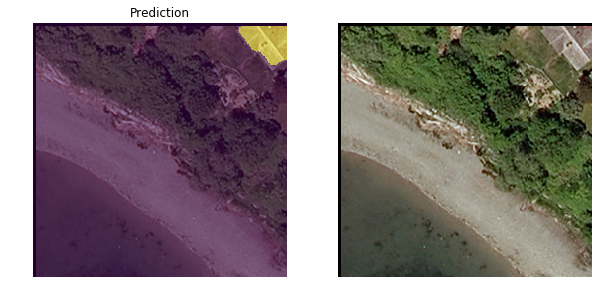

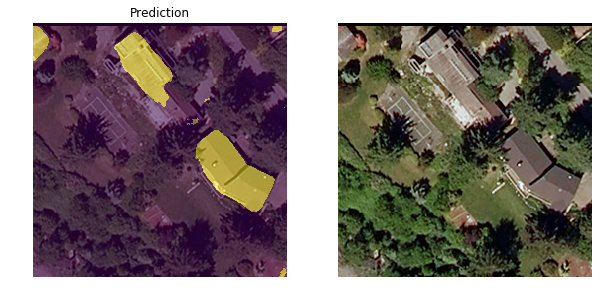

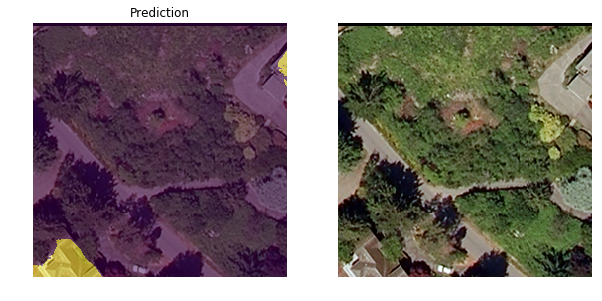

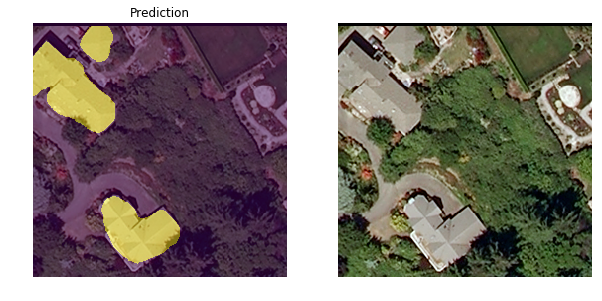

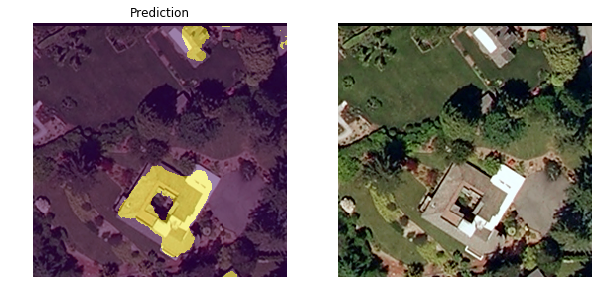

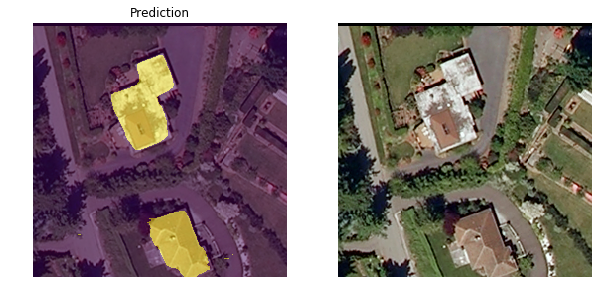

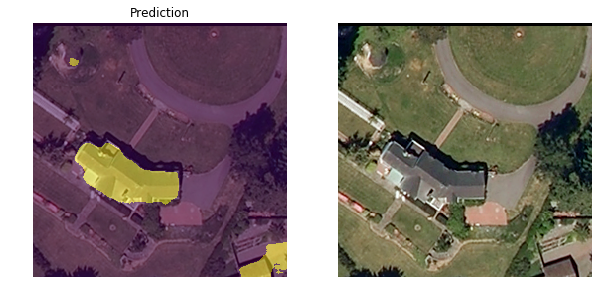

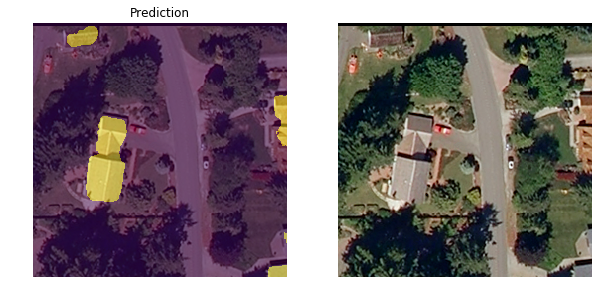

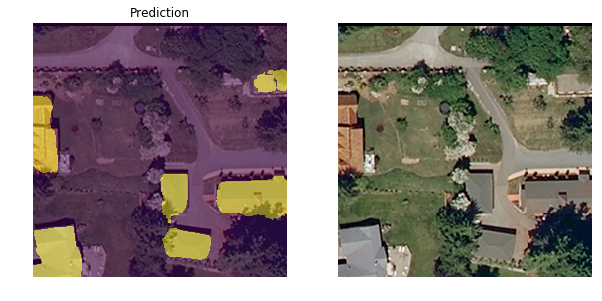

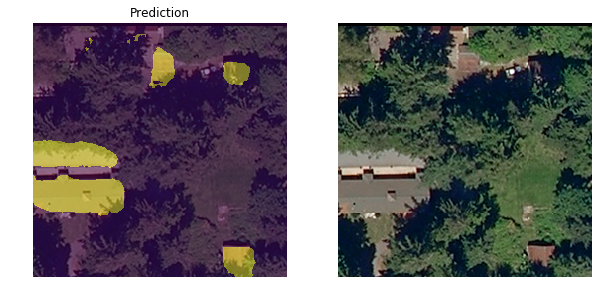

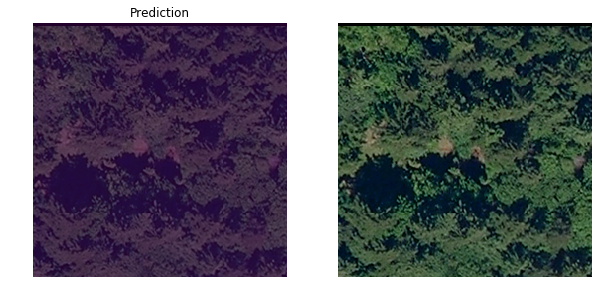

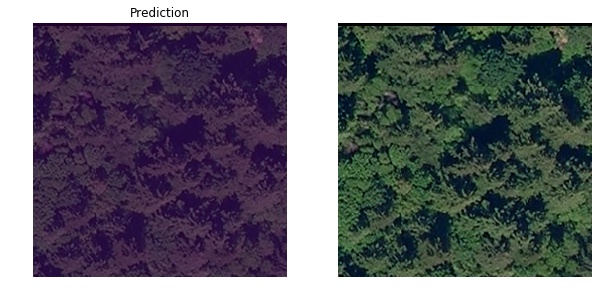

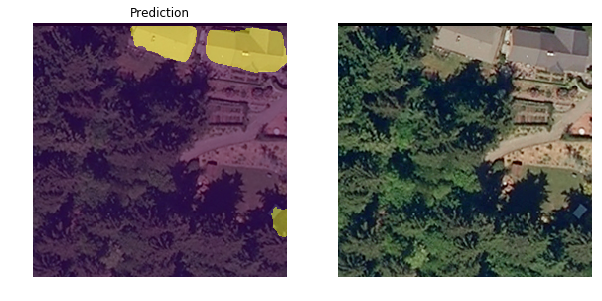

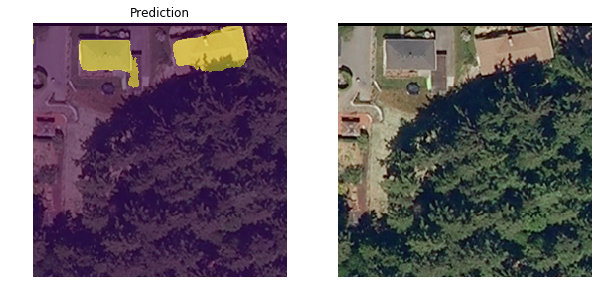

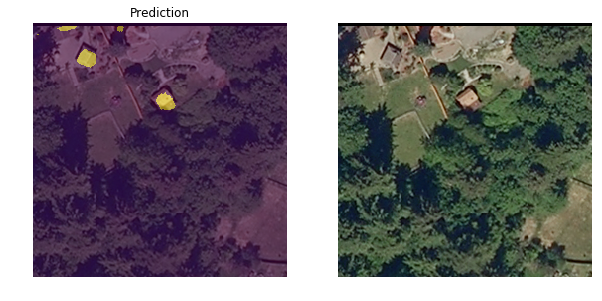

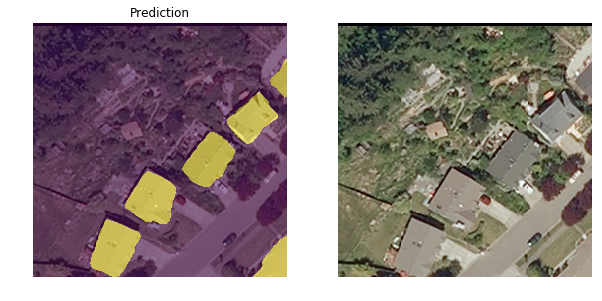

In [18]:
# Comparing Model's prediction on test images and Original test images
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data_test.test_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(preds[i][1].sigmoid()>0.50)), alpha=0.5)
#     ax1.imshow(predictions[i], alpha=0.5)
    
    ax2.set_title('Original')
    data_test.test_ds.x[i].show(ax=ax2)
    data_test.test_ds.y[i].show(ax=ax2, alpha=0.5)
    plt.show()

In [0]:
## If need to to convert the prediction images to 0-255 from 0-1 values before stitching
# mean = torch.tensor(imagenet_stats[0], dtype=torch.float32)
# std = torch.tensor(imagenet_stats[1], dtype=torch.float32)
# prediction[1].float()*std[...,None,None] + mean[...,None,None]

**Inference based on Inria submission requirements:**

In [0]:
!mkdir '/content/InriaPatches/test_gt'

In [0]:
# Define variables needed for stitching the sliced image to original resolution image
original_size = 5000
overlap = 6
pad = 3
patch_size = 256
pw = patch_size - overlap
ph = patch_size - overlap
w = original_size
h = original_size
nrow=original_size//ph
dest_img_path = Path('/content/InriaPatches/test_gt')
get_file_name = lambda pth,x: pth/f'{x.stem}.tif'

In [0]:
def stitch_patches(predictions, img_name):
  new_img = torch.zeros([3, w, h])
  k=0
  for i in range(nrow):
      for j in range(nrow):
          patch_pixels = predictions[k]
          if overlap==0 and pad==0:
            new_img[:, pw*i: pw*(i+1), ph*j: ph*(j+1)] = patch_pixels [:,:,:]
          elif pad!=0:
            #remove half overlap front and half at end of patch so that pad removed
            new_img[:, pw*i: pw*(i+1), ph*j: ph*(j+1)] = patch_pixels [:,pad:-pad,pad:-pad]
          k = k+1 
  imgpil = F.to_pil_image(new_img)
  filname = get_file_name(dest_img_path, img_name)
  imgpil.save(filname)

In [0]:
testfiles=[]
for test in os.listdir(test_path):
  testfiles.append(test_path/test.split("_")[0])
testfiles = list(set(testfiles))  #Getting original test image names instead of sliced image names

In [74]:
#Predicting for each test image - 180 images
for test in tqdm(testfiles):
  predictions=[]
  for i in range(1,401): # 1 test image = 400 sliced images 
    imgfile = str(test)+'_'+str(i)+'.tif'
    img = open_image(imgfile)
    prediction = learn.predict(img)
    predictions.append(prediction[1])
  stitch_patches(predictions,test)  

100%|██████████| 180/180 [35:27<00:00, 12.27s/it]


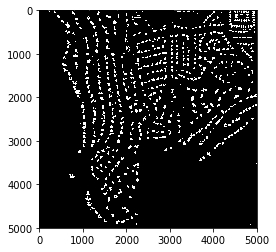

In [79]:
#One of the saved stitched image
img = plt.imread('/content/InriaPatches/test_gt/bellingham1.tif')
plt.imshow(img)

In [0]:
pred_source_dir = '/content/InriaPatches/test_gt'
def make_tarfile(output_filename, source_dir):
  with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(source_dir, arcname=os.path.basename(source_dir))
    
make_tarfile('test_gt.tar', pred_source_dir)

In [0]:
!cp '/content/test_gt.tar' 'drive/My Drive/256_tif_files' 